# Watson Datatset - Multi-language NLI Task using Multi-Language Bert
- Can use Kaggle TPUs for faster training
- Uses HuggingFace transformers library to access weights of pre-trained models
- Utilizes TensorFlow framework for deep learning
- Perform fine tuning for classifying watson dataset sentence pairs as entailment, neutral, and contradiction in 15 different languages.

In [1]:
!pip install plotly seaborn datasets transformers sentencepiece --quiet


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
#import warnings
#warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
import tensorflow as tf

D0831 00:16:05.406487161      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0831 00:16:05.406512911      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0831 00:16:05.406517125      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0831 00:16:05.406520388      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0831 00:16:05.406523449      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0831 00:16:05.406534564      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0831 00:16:05.406537516      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0831 00:16:05.

In [3]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

Load in train and test sets from dataset into pandas. Remove a few of the columns that we don't neeed. We'll keep: id, premise, hypothesis, and label.

In [4]:
RANDOM_STATE = 123

# Load train and test pandas DataFrames
train_df = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/train.csv')  # Change to your train file path
test_df = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/test.csv')    # Change to your test file path

# Further split into train, validation and test
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=123)

# Finally, let's shuffle the data before we start batching
train_df = train_df.sample(frac=1, random_state=RANDOM_STATE)
val_df = val_df.sample(frac=1, random_state=RANDOM_STATE)

train_df

,id,premise,hypothesis,lang_abv,language,label
11650,0d6c6e2c98,"В Эр-Рияде он сообщил своим братьям, что был н...",Все три из его братьев намеревались поехать в ...,ru,Russian,1
413,489ba2482b,Chatterbox queried Trudeau about the Dallas Mo...,Trudeau was queried by Chatterbox about his qu...,en,English,0
3680,4583cf84e6,Search out the House of Dionysos and the House...,The floor patterns of the House of the Trident...,en,English,2
7975,4978ccf43a,Голос его светлости прозвучал еще холоднее и о...,Как лорд он не проявлял ни капли милосердия к ...,ru,Russian,1
10539,91acc0d350,اور وہ ، میرے دادا اچھے آدمی نہیں تھے۔,میرے دادا/نانا واقعی نسل پرست اور کم ظرف تھے۔,ur,Urdu,1
...,...,...,...,...,...,...
1663,f88e8731d2,because i i mean i don't know it's just someth...,I think it is completely unnecessary.,en,English,2
1702,e6f845b6bb,yeah okay you go ahead,"No, do not go ahead.",en,English,2
6497,295b489f02,पंडित अक्सर कहते हैं कि इतिहास विजेताओं द्वारा...,पंडित कहते हैं कि हारने वाले इतिहास रचते हैं।,hi,Hindi,2
10147,8a627866c5,He asserted that the area was blessed with the...,He implied that this area was a beautiful place.,en,English,0


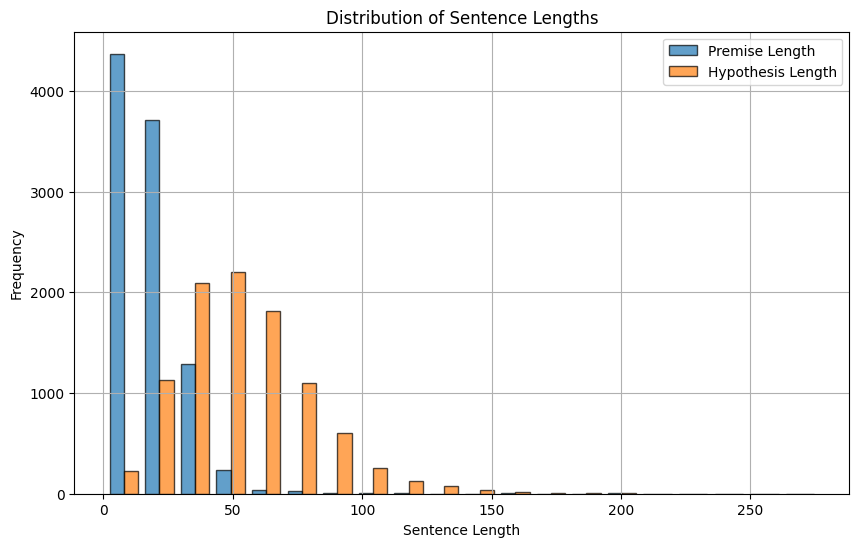

In [5]:
analysis = train_df.copy()
analysis["premise_length"] = analysis["premise"].apply(lambda x : len(x.split()))
analysis["hypothesis_length"] = analysis["hypothesis"].apply(lambda x : len(x))

plt.figure(figsize=(10, 6))
plt.hist([analysis['premise_length'], analysis['hypothesis_length']], 
         bins=20, edgecolor='black', alpha=0.7, 
         label=['Premise Length','Hypothesis Length'])
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


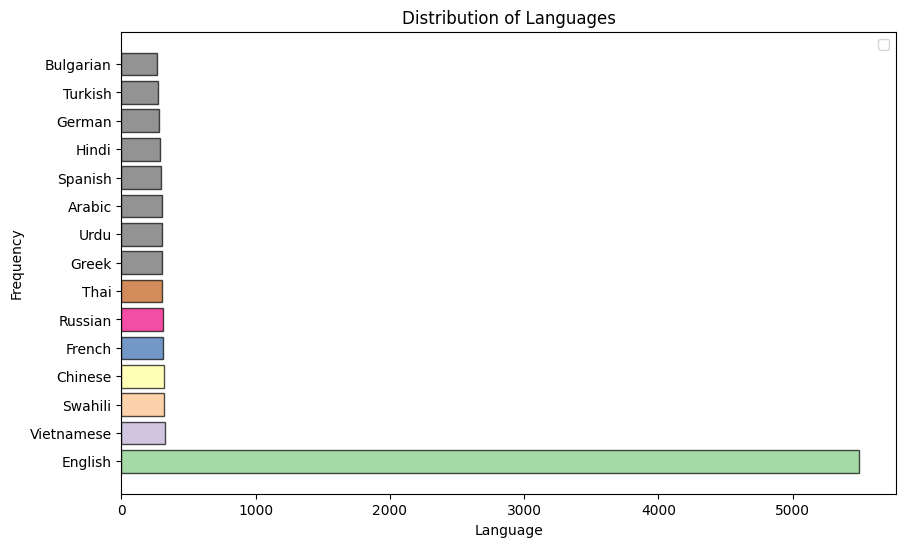

In [6]:
# Plot language distribution
import matplotlib.cm as cm
lang_counts = analysis['language'].value_counts() # Returns pandas series
plt.figure(figsize=(10, 6))
colors = cm.Accent(range(len(lang_counts)))
plt.barh(lang_counts.index,
        lang_counts.values,
        edgecolor='black', alpha=0.7, color=colors)
plt.title('Distribution of Languages')
plt.xlabel('Language')
plt.ylabel('Frequency')
plt.legend()
#plt.grid(True)
plt.show()

### Tokenizing Text
- Import tokenizer from HuggingFace
- Get tokenized pairs of premise and hypothesis, adding padding, truncation, etc.
- Finally, create TF datasets in form feedable to TF model which should be ({input_ids, attention_mask}, labels) tuple format.

In [7]:
!pip install ipywidgets --quiet


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [8]:
# Login to HuggingFace to use gated model
#from huggingface_hub import notebook_login
#notebook_login()


In [9]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("access_token")

In [ ]:
# Set up the notebook to use HF hub to use gated models
!python -c "from huggingface_hub.hf_api import HfFolder; HfFolder.save_token(secret_value_0)"

In [10]:
# Import our model and turn off transformers warnings
import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
transformers.logging.set_verbosity_error()

access_token = secret_value_0
model_name = 'joeddav/xlm-roberta-large-xnli'
# Declare the tokenizer for this model
tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)

NOTE on BATCH and BUFFER sizes: We should keep in mind that a larger buffer_size provides more randomness but requires more memory. A smaller buffer_size is more memory-efficient but might result in less effective shuffling. A couple of options:

1. Small Dataset (Fits in Memory): Set buffer_size to be >= size of dataset. All examples are considered for shuffling. Ex. buffer_size = len(dataset) + extra_padding

2. Large Dataset (bigger than memory): Set buffer_size to fraction of dataset size. Ex. buffer_size = len(dataset) // 10

3. Streaming Data: Use buffer size that corresponds to a small batch size. Ex. buffer_size = batch_size

In [11]:
BUFFER_SIZE = train_df.shape[0]
BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync #64
MAX_LENGTH = 128

In [24]:
# Declare function to get tokenized sentence pairs as TF tensor datasets
def get_batched_tokenized_tensors(df, data_name, tokenizer, batch_size, max_length=MAX_LENGTH):

    # Tokenize the premise and hypothesis pairs for train and test sets. Returns dict of input_ids and attention mask
    tokenized_pairs = tokenizer(
        text=df['premise'].tolist(),
        text_pair=df['hypothesis'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors='tf'
    )
    
    if data_name in ['val', 'train']:
        # Get the labels as a list to pass into a tensor
        labels = df['label'].tolist()

        # Create a tensorflow data set from the tokenizer's output
        dataset = tf.data.Dataset.from_tensor_slices(
            ({'input_ids': tokenized_pairs['input_ids'],
              'attention_mask': tokenized_pairs['attention_mask'],
              'token_type_ids': tokenized_pairs['token_type_ids']},
            labels)
        )

        # Shuffle and batch the sets. Use repeat() on the train/val for multiple epochs
        if data_name == 'train':    
            dataset = dataset.shuffle(BUFFER_SIZE).batch(batch_size).repeat() # Use with steps_per_epoch
            #dataset = dataset.shuffle(BUFFER_SIZE).batch(batch_size) # Use with no steps_per_epoch
        elif data_name == 'val':
            dataset = dataset.shuffle(BUFFER_SIZE).batch(batch_size)
    elif data_name == 'test':
        dataset = tf.data.Dataset.from_tensor_slices(
            ({'input_ids': tokenized_pairs['input_ids'],
              'attention_mask': tokenized_pairs['attention_mask'],
              'token_type_ids': tokenized_pairs['token_type_ids']}))
        dataset = dataset.batch(batch_size)
    return dataset

train_dataset = get_batched_tokenized_tensors(train_df, 'train', tokenizer, BATCH_SIZE, BUFFER_SIZE)
val_dataset = get_batched_tokenized_tensors(val_df, 'val', tokenizer, BATCH_SIZE, BUFFER_SIZE)
test_dataset = get_batched_tokenized_tensors(test_df, 'test', tokenizer, BATCH_SIZE, BUFFER_SIZE)

In [13]:
# Explore data set a bit to make sure things look ok
sample = train_dataset.take(1)
num_examples = sample.cardinality().numpy()
print("Number of Examples:", num_examples)
for inputs, labels in sample:
    print("Input IDs:", inputs['input_ids'][0])
    print("Attention Mask:", inputs['attention_mask'][0])
    print("Token Type IDs:", inputs['token_type_ids'][0])
    print("Labels:", labels)

Number of Examples: 1
Input IDs: tf.Tensor(
[     0    581  14364      4  11617  14912      4   1556   8306  37842
     47  14192     10  13765    237  27140     15    748    351  10023
  22042     16    237    581 189635      6      4    136    764    136
   1919    552      9  86667  70035      4  51838 137514      4   2301
     25     18 115700   2363  29718   4935   4552  40407  38543    538
      5      2      2  11617  14912   8951    297    442      5      2
      1      1      1      1      1      1      1      1      1      1
      1      1      1      1      1      1      1      1      1      1
      1      1      1      1      1      1      1      1      1      1
      1      1      1      1      1      1      1      1      1      1
      1      1      1      1      1      1      1      1      1      1
      1      1      1      1      1      1      1      1      1      1
      1      1      1      1      1      1      1      1], shape=(128,), dtype=int32)
Attention Mask: tf

In [14]:
LEARNING_RATE = 2e-5
NUM_LABELS = 3

The method below will create a model with the built in classifier head from HuggingFace. We'll use this as a baseline before creating a custom classifier head later.
- Note the use of 'use_auth_token=True' which allows us to use a gated model from HF.

In [15]:
def build_model(model_name, config):
    
    nli_model = TFAutoModelForSequenceClassification.from_pretrained(model_name,
                                                                     config=config, 
                                                                     use_auth_token=True)
    # Declare the loss function with the constructor so we can specify from logits is true.
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # Declare optimizer as well so we can pass a learning rate scheduler later
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')       
    
    # Compile the model with specified loss and optimizer and metrics
    nli_model.compile(optimizer=optimizer, 
                      loss=loss,
                      metrics=[metric])


    return nli_model

- Now we'll build the full model with a custom classifier head. This will output a model. The default initializer for the weights is GlorotUniform.
- We'll use 3 input layers for the 3 parts of our TF dataset.
- Create custom layer and grab the CLS token for classification from the top for every entry in batch

In [16]:
def build_model_with_classifier_head(model_name, config, max_length=MAX_LENGTH):
    # Initialize the model with the custom configuration
    model = TFAutoModel.from_pretrained(model_name, config=config, use_auth_token=True)

    # Temporarily, freeze the layers of the model until later.
    for layer in model.layers:
        layer.trainable = False

    # Get random initialization of head by hand, so we can specify random seed.
    initial_weights = tf.keras.initializers.GlorotNormal(seed=RANDOM_STATE)

    # Our inputs are the pieces of the TF dataset we made, the index_ids,attention, etc.
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    attention_mask_layer = tf.keras.layers.Input(shape=(max_length, ),
                                                 name='attention_mask',
                                                 dtype='int32')
    token_type_ids_layer = tf.keras.layers.Input(shape=(max_length, ),
                                                name='token_type_ids',
                                                dtype='int32')

    # We need the outputs from the base model. The last hidden state b4 classifier layer
    # This will be (batch_size, sequence_length, hidden_size)
    last_hidden_layer = model([input_ids_layer,attention_mask_layer,token_type_ids_layer])[0]

    # We only care about the [CLS] token's representation. Returns tensor (batch_size, hidden_size)
    cls_token = last_hidden_layer[:, 0, :]

    # Define dropout and then Dense layer using TF functional paradigm
    #x = tf.keras.layers.Dropout(0.2)(cls_token)
    x = tf.keras.layers.Dropout(0.1)(cls_token)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    # For this NLI task, use final dense layer of size 3 with softmax
    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

    # Finally, declare the model
    nli_model = tf.keras.Model(inputs=[input_ids_layer, attention_mask_layer, 
                                       token_type_ids_layer],
                               outputs=outputs)

    # Declare the loss function with the constructor so we can specify from logits is true.
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # Declare optimizer as well so we can pass a learning rate scheduler later
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')    
    
    # Compile the model with specified loss and optimizer and metrics
    nli_model.compile(optimizer=optimizer, loss = loss, metrics = [metric])
    
    return nli_model

In [17]:
from transformers import TFAutoModel,AutoConfig, TFAutoModelForSequenceClassification

# Set a default config setup, then modify parameters later
config = AutoConfig.from_pretrained(model_name)

# Modify configuration attributes as needed
config.output_hidden_states = True 
config.hidden_dropout_prob = 0.2
config.attention_probs_dropout_prob = 0.2
config.classifier_dropout = 0.2
config.num_labels = NUM_LABELS

with tpu_strategy.scope():
    #bert_model_nli = build_model_with_classifier_head(model_name,config,max_length=MAX_LENGTH)
    bert_model_nli = build_model(model_name, config)

/usr/local/lib/python3.8/site-packages/transformers/models/auto/auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [18]:
bert_model_nli.summary()

Model: "tfxlm_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFXLMRobertaMainLa  multiple                 558840832 
 yer)                                                            
                                                                 
 classifier (TFXLMRobertaCla  multiple                 1052675   
 ssificationHead)                                                
                                                                 
Total params: 559,893,507
Trainable params: 559,893,507
Non-trainable params: 0
_________________________________________________________________


When we do use a custom classification head, we will have the following workflow (note this does not apply when just using built in classification head):
1. Initial Pretraining: 
- Load the pretrained XLM-RoBERTa model with the classification head on top.
- Freeze the weights of the base model.
- Train the classification head using NLI data.

2. Fine-Tuning:
- Unfreeze some or all of the weights in the base model.
- Use a smaller learning rate than the initial training phase.
- Train the entire model (base model + classification head) using NLI data.

Our training dataset has 9696 inputs. Our batch size is currently set to 128 based on Kaggle TPU recommendations. Our steps per epoch recommended was train_df.shapep[0] // BATCH_SIZE which is 75. We need 450 (steps*epochs = 75*6 = 450) batches. 

In [19]:
EPOCHS = 25
STEPS_PER_EPOCH = train_df.shape[0] // BATCH_SIZE
VALIDATION_STEPS = val_df.shape[0] // BATCH_SIZE

# Create early stopping callback to stop if validation accuracy isn't improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=4,               # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model, keeping in mind the TPU strategy
history = bert_model_nli.fit(train_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = STEPS_PER_EPOCH,
    validation_data = val_dataset,
    validation_steps = VALIDATION_STEPS,
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/25


/usr/local/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:459: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  warnings.warn(
2023-08-31 00:19:03.906417: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-31 00:19:06.247686: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-31 00:21:10.425135: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-31 00:21:10.993313: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


75/75 - 222s - loss: 0.9207 - accuracy: 0.5650 - val_loss: 0.5285 - val_accuracy: 0.8073 - 222s/epoch - 3s/step
Epoch 2/25
75/75 - 120s - loss: 0.3738 - accuracy: 0.8618 - val_loss: 0.2785 - val_accuracy: 0.9136 - 120s/epoch - 2s/step
Epoch 3/25
75/75 - 23s - loss: 0.2320 - accuracy: 0.9162 - val_loss: 0.3456 - val_accuracy: 0.9141 - 23s/epoch - 310ms/step
Epoch 4/25
75/75 - 21s - loss: 0.1679 - accuracy: 0.9409 - val_loss: 0.3464 - val_accuracy: 0.9045 - 21s/epoch - 283ms/step
Epoch 5/25
75/75 - 23s - loss: 0.1289 - accuracy: 0.9538 - val_loss: 0.3795 - val_accuracy: 0.9162 - 23s/epoch - 309ms/step
Epoch 6/25
75/75 - 21s - loss: 0.1033 - accuracy: 0.9637 - val_loss: 0.4459 - val_accuracy: 0.9084 - 21s/epoch - 282ms/step
Epoch 7/25
75/75 - 21s - loss: 0.0879 - accuracy: 0.9705 - val_loss: 0.3694 - val_accuracy: 0.9062 - 21s/epoch - 284ms/step
Epoch 8/25
75/75 - 21s - loss: 0.0636 - accuracy: 0.9787 - val_loss: 0.4572 - val_accuracy: 0.9145 - 21s/epoch - 283ms/step
Epoch 9/25
75/75 - 37

In [20]:
val_results = bert_model_nli.evaluate(val_dataset)

19/19 [==============================] - 14s 696ms/step - loss: 0.3877 - accuracy: 0.9138


Below, we will set up code for the fine tuning process to train the entire model AFTER having already trained the classificaiton head layers. Again, note that this only applies when utilizing the custom classification head.

In [21]:
'''
# For fine tuning, make the layers of the xlm_model_nli trainable
for layer in bert_model_nli.layers:
    layer.trainable = True

# Choose a smaller learning (roughly half of the old one). Do a few fewer epochs
LEARNING_RATE_FT = 2e-5
EPOCHS_FT = 4

# Delcare TPU scope when compiling new FT model
with tpu_strategy.scope():
    # Compile the new fine tuning model
    bert_model_nli.compile(optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE_FT), 
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    # Define a call back that 
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  mode='min',
                                                  min_delta=0,
                                                  patience=0,
                                                  restore_best_weights=True)

# Train the model for fine_tuning, creating a new history
history_FT = bert_model_nli.fit(
    train_dataset,
    epochs = EPOCHS_FT,
    batch_size = BATCH_SIZE,
    steps_per_epoch = STEPS_PER_EPOCH,
    validation_data = val_dataset,
    callbacks=[early_stopping],
    #verbose=2
    )
'''

"\n# For fine tuning, make the layers of the xlm_model_nli trainable\nfor layer in bert_model_nli.layers:\n    layer.trainable = True\n\n# Choose a smaller learning (roughly half of the old one). Do a few fewer epochs\nLEARNING_RATE_FT = 2e-5\nEPOCHS_FT = 4\n\n# Delcare TPU scope when compiling new FT model\nwith tpu_strategy.scope():\n    # Compile the new fine tuning model\n    bert_model_nli.compile(optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE_FT), \n                      loss='sparse_categorical_crossentropy',\n                      metrics=['accuracy'])\n\n    # Define a call back that \n    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',\n                                                  mode='min',\n                                                  min_delta=0,\n                                                  patience=0,\n                                                  restore_best_weights=True)\n\n# Train the model for fine_tuning, creating a ne

Now that we have fine tuned the entire model,we can run testing on it using the same process as was done for val.

In [25]:
# Create predictions using the test_dataset we created earlier
predictions = bert_model_nli.predict(test_dataset)

2023-08-31 00:33:12.803048: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-31 00:33:13.435067: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


41/41 [==============================] - 45s 592ms/step


In [26]:
# Create submission by taking IDs from the test DF and creating DF.
submission = test_df.id.copy().to_frame()

# Get the logits from the predictions of the model
logits_array = predictions.logits

# From the logits, get the max argument to get the class
submission["prediction"] = np.argmax(logits_array, axis=-1)

submission

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,1
...,...,...
5190,5f90dd59b0,1
5191,f357a04e86,2
5192,1f0ea92118,0
5193,0407b48afb,0


In [27]:
# Finally, output a submission file for the competition
submission.to_csv("submission.csv", index=False)